### Generalized Local States Example

This example depicts the basic use of generalized local states in the context 
of RC as implemented in rescomp.esn.ESNGenLoc()

A more detailed explanation of generalized local states is given here:  
[Baur, S.; Räth, C. Predicting High-Dimensional Heterogeneous Time Series Employing Generalized Local States. Phys. Rev. Res. 2021, 3, 23215.](
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.023215)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import rescomp
from rescomp.simulations import simulate_trajectory

Simulation Parameters

In [13]:
ks_dim = 40  # 40 or 64
ks_size = 22  # 22
ks_dt = 0.5  # 0.05

shuffle = False
disc_ts = int(1e4)
sync_ts = int(2e3)
train_ts = int(2e4)
pred_ts = int(1e3)

tot_ts = disc_ts + 2 * sync_ts + train_ts + pred_ts

Simulation

In [14]:
np.random.seed(1)
ks_signal = simulate_trajectory(
    sys_flag="kuramoto_sivashinsky", dimensions=ks_dim,
    system_size=ks_size, dt=ks_dt, time_steps=tot_ts)

Plot the simulation

Text(0, 0.5, 'Dimension')

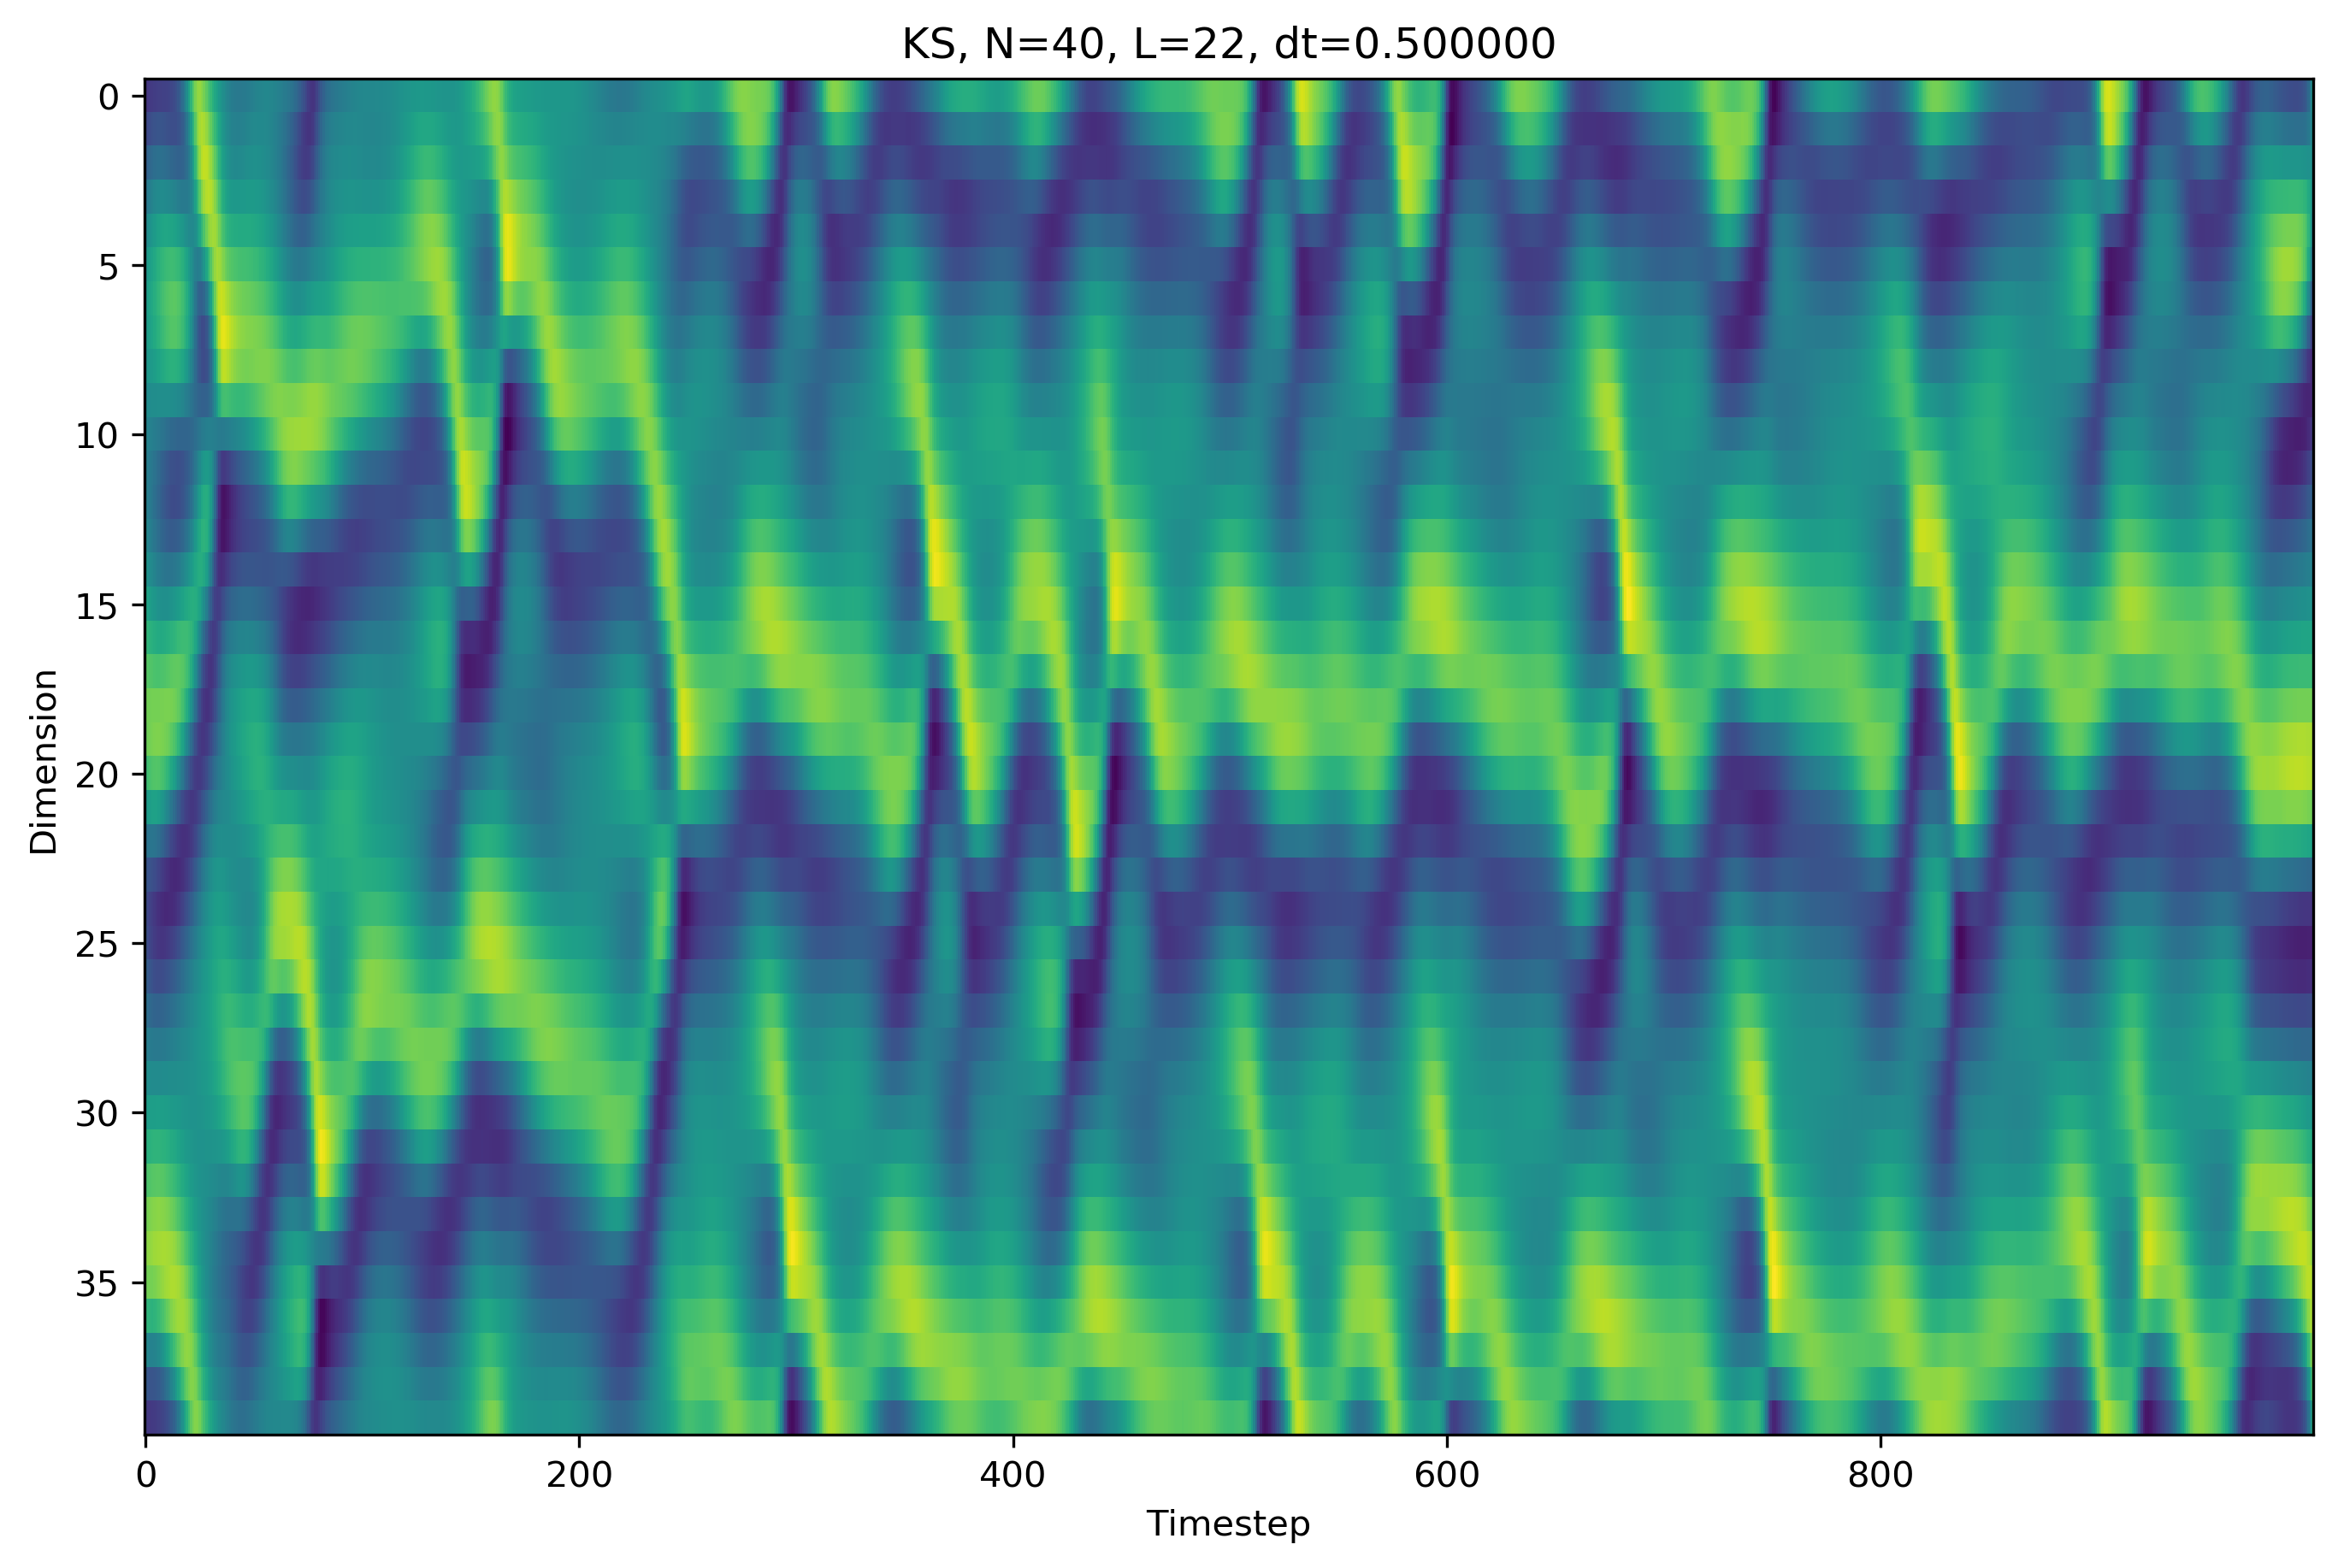

In [15]:
ks_title = "KS, N=%d, L=%d, dt=%f"%(ks_dim, ks_size, ks_dt)

ks_axis_ranges = [-pred_ts, tot_ts]

ks_xlabel = "Timestep"
ks_ylabel = "Dimension"

signal_raw = ks_signal
y_test = ks_signal[ks_axis_ranges[0]: ks_axis_ranges[1]]

fig, ax = plt.subplots(1, 1, figsize=(9, 6), constrained_layout=True, dpi=300)

vmin = np.min(y_test)
vmax = np.max(y_test)

im = ax.imshow(y_test.T, aspect='auto', vmin=vmin, vmax=vmax)

ax.set_title(ks_title)
ax.set_xlabel(ks_xlabel)
ax.set_ylabel(ks_ylabel)

Add normal noise to the training data.
This is not necessary for the generalized local state code to work, but it's 
more realistic and increases long term prediction accuracy.
Note that we don't add noise to the data used to test the prediction.

In [16]:
noise_scale = 1e-2

ts_until_train_end = disc_ts + sync_ts + train_ts
noise = np.random.normal(scale=noise_scale, size=[ts_until_train_end, signal_raw.shape[1]])
signal = np.copy(signal_raw)
signal[:noise.shape[0]] = signal[:noise.shape[0]] + noise

Calculate the different locality matrices, then put them into neighborhoods.

* SN: Spatial neighborhood. Just put the spatially closest dimensions together. 
Spatial in this case refers to the dimension's index, so dimension 2 is closer
to dimension 3 than it is to dimension 15.
* CC: Cross Correlation Neighborhood. Locality is calculated via the cross 
correlation between dimensions. 
* NMI: (Normalized) Mutual Information Neihborhood. Locality is calculated via
via the normalized mutual information between dimensions.

We also set the number of neighbors to 18, simply because it works well for this
iteration of the KS system used as data here.  
A larger number of neighbors results in a possibly better prediction at the 
cost of requiring larger reservoirs and longer training times.
Making the neighborhood too small though, will cut out important dimensions, 
possibly reducing prediction accuracy or making training completely impossible.  
If you don't know your neighborhood size a priori just treat the neighborhood 
size as another hyperparameter to optimize somewhere in the range of 10 to 50 
and you will probably be fine. 

For more detail on how the above is implemented exactly, please read 
[Baur, Räth 2021, PRR](
https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.3.023215)

In [17]:
sn_loc_matrix = rescomp.locality_measures.sn_loc(signal)
cc_loc_matrix = rescomp.locality_measures.cc_loc(signal)
nmi_loc_matrix = rescomp.locality_measures.nmi_loc(signal)

nbs = 18 # Nr. of neighbors in each neighborhood

sn_nbhds = rescomp.locality_measures.find_local_neighborhoods(
                sn_loc_matrix, neighbors=nbs)
cc_nbhds = rescomp.locality_measures.find_local_neighborhoods(
                cc_loc_matrix, neighbors=nbs)
nmi_nbhds = rescomp.locality_measures.find_local_neighborhoods(
                nmi_loc_matrix, neighbors=nbs)

Define a plotting helper function to make the labels in the plots below look
nicer.

In [18]:
import matplotlib.patches as mpatches

def force_colorbar_legend(ax, im, labels, label_values):
    label_colors = [im.cmap(im.norm(value)) for value in label_values]

    patches = [mpatches.Patch(label=labels[i], color=label_colors[i])
               for i in range(len(label_values))]

    ax.legend(handles=patches, bbox_to_anchor=(1.02, 1), loc=2,
              borderaxespad=0.)

Plot the three neighborhoods we calculated above.

For 'simple' systems defined by a purely local interaction which is known a 
priori, as is the case for the KS system we simulated above, the SN neighborhood 
is essentially the 'correct' neighborhood. 
That the CC and MI neighborhoods are able to reproduce the SN neighborhood to 
such a degree is a strong indication that they actually "understood" the 
relation between the dimensions in this case.

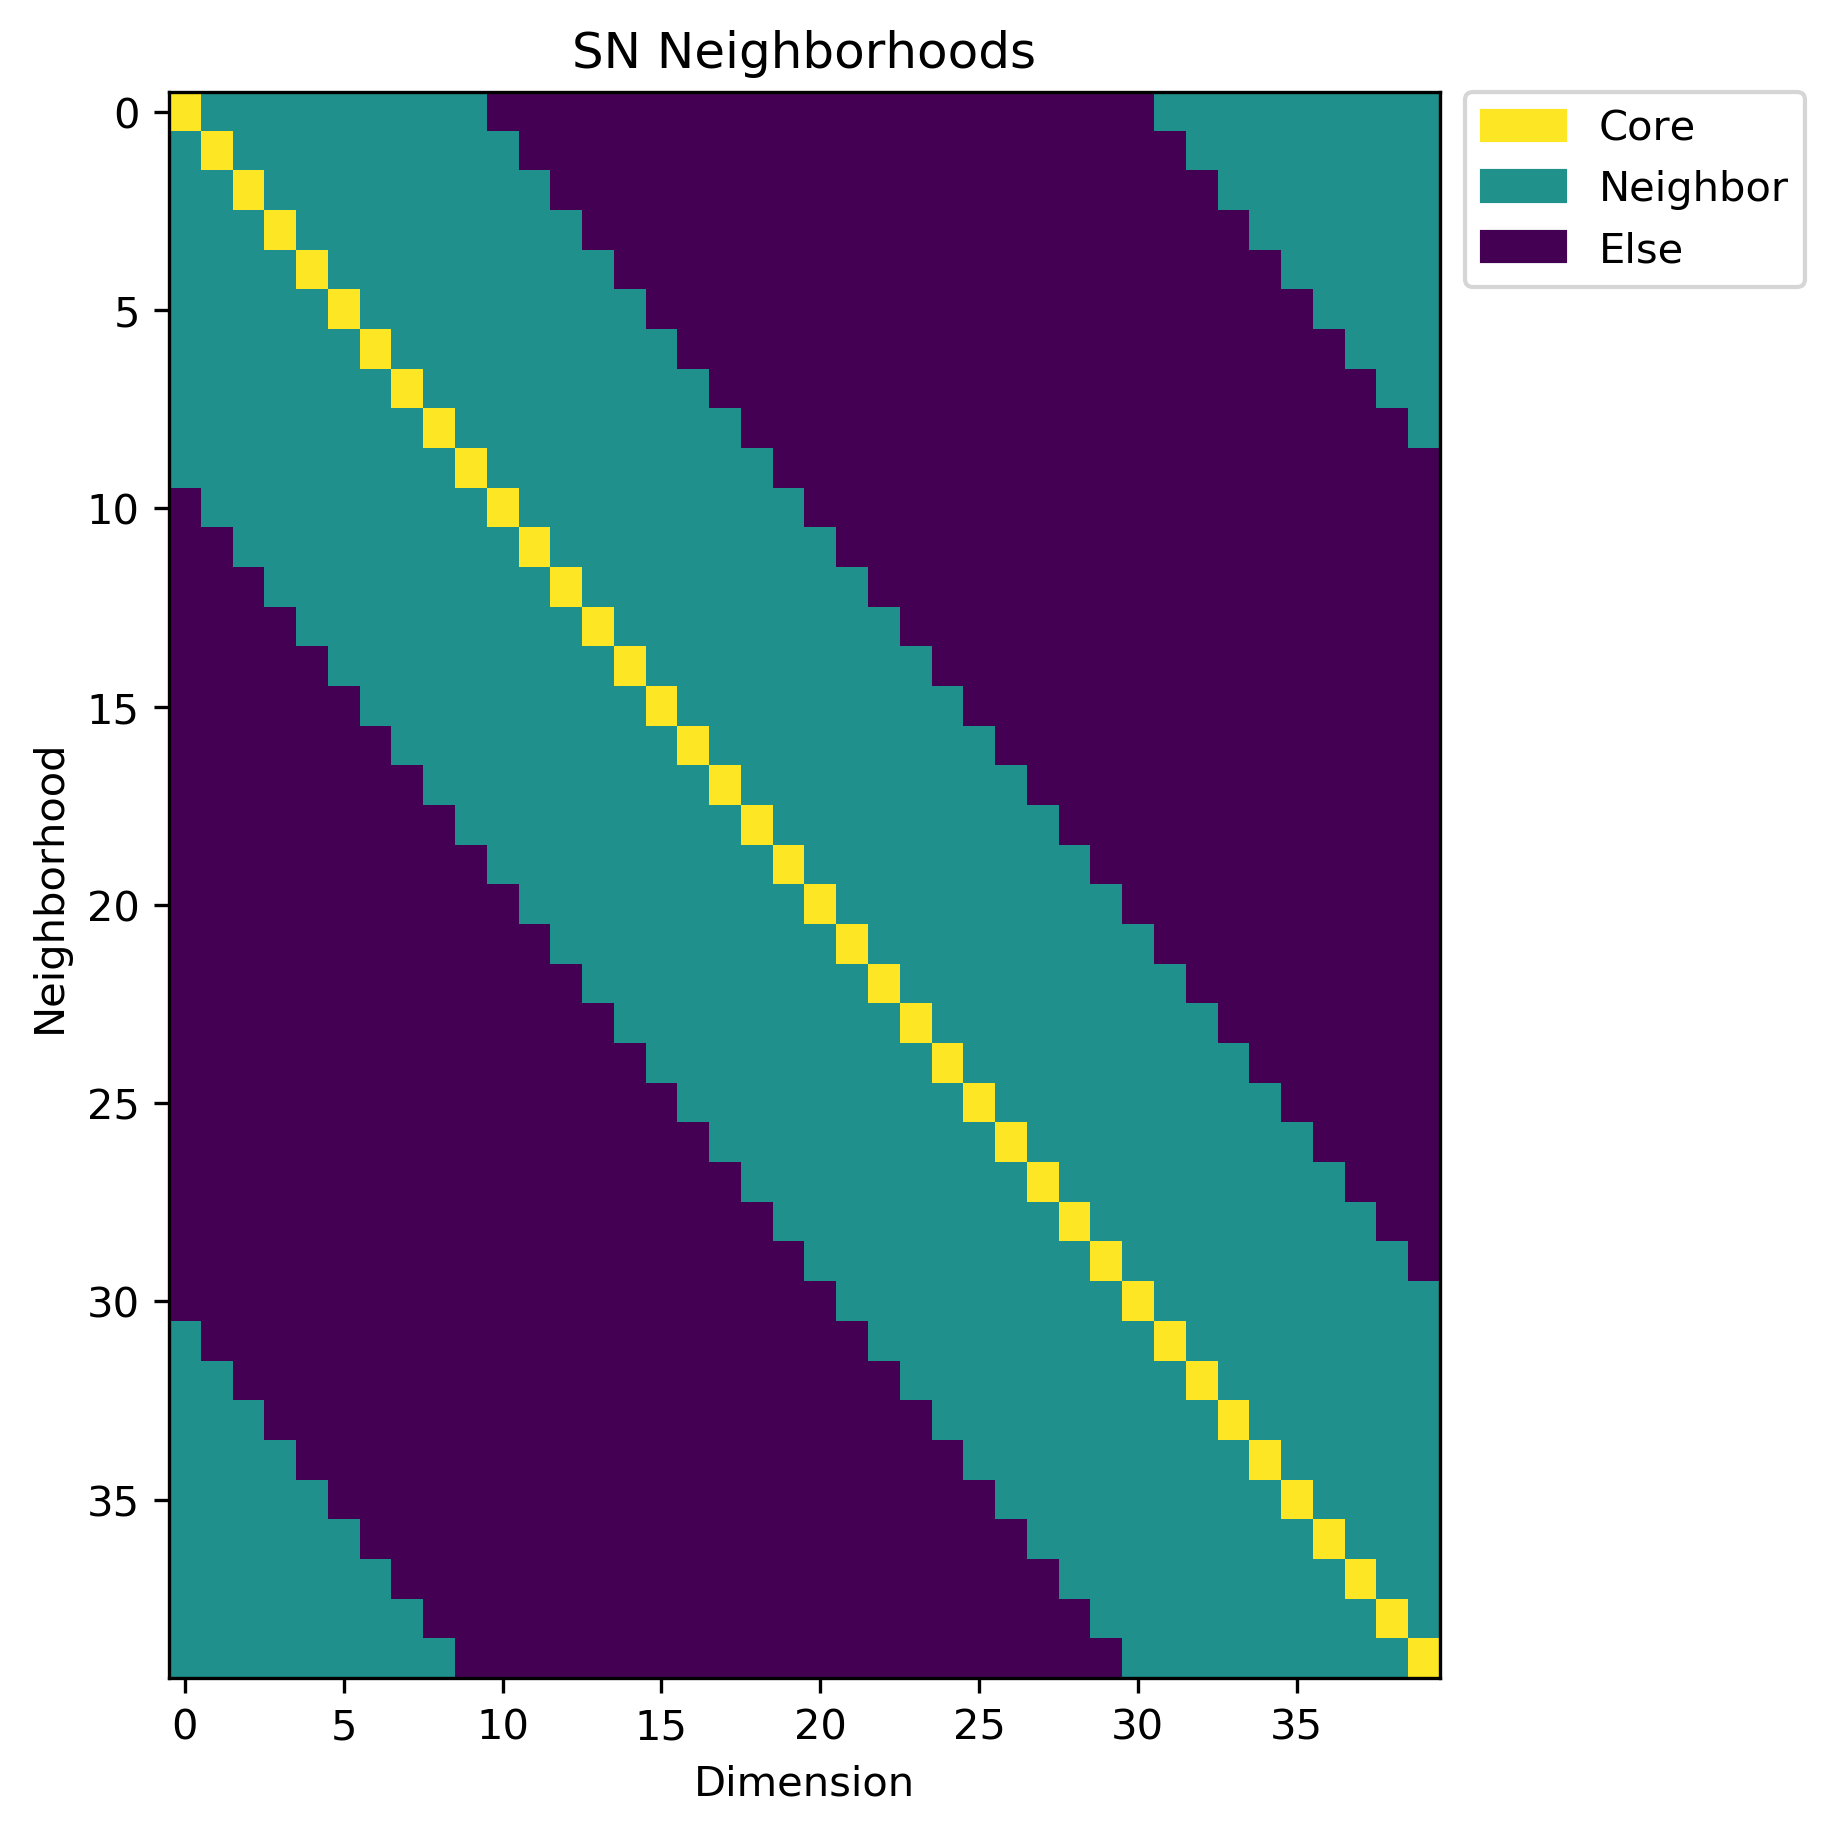

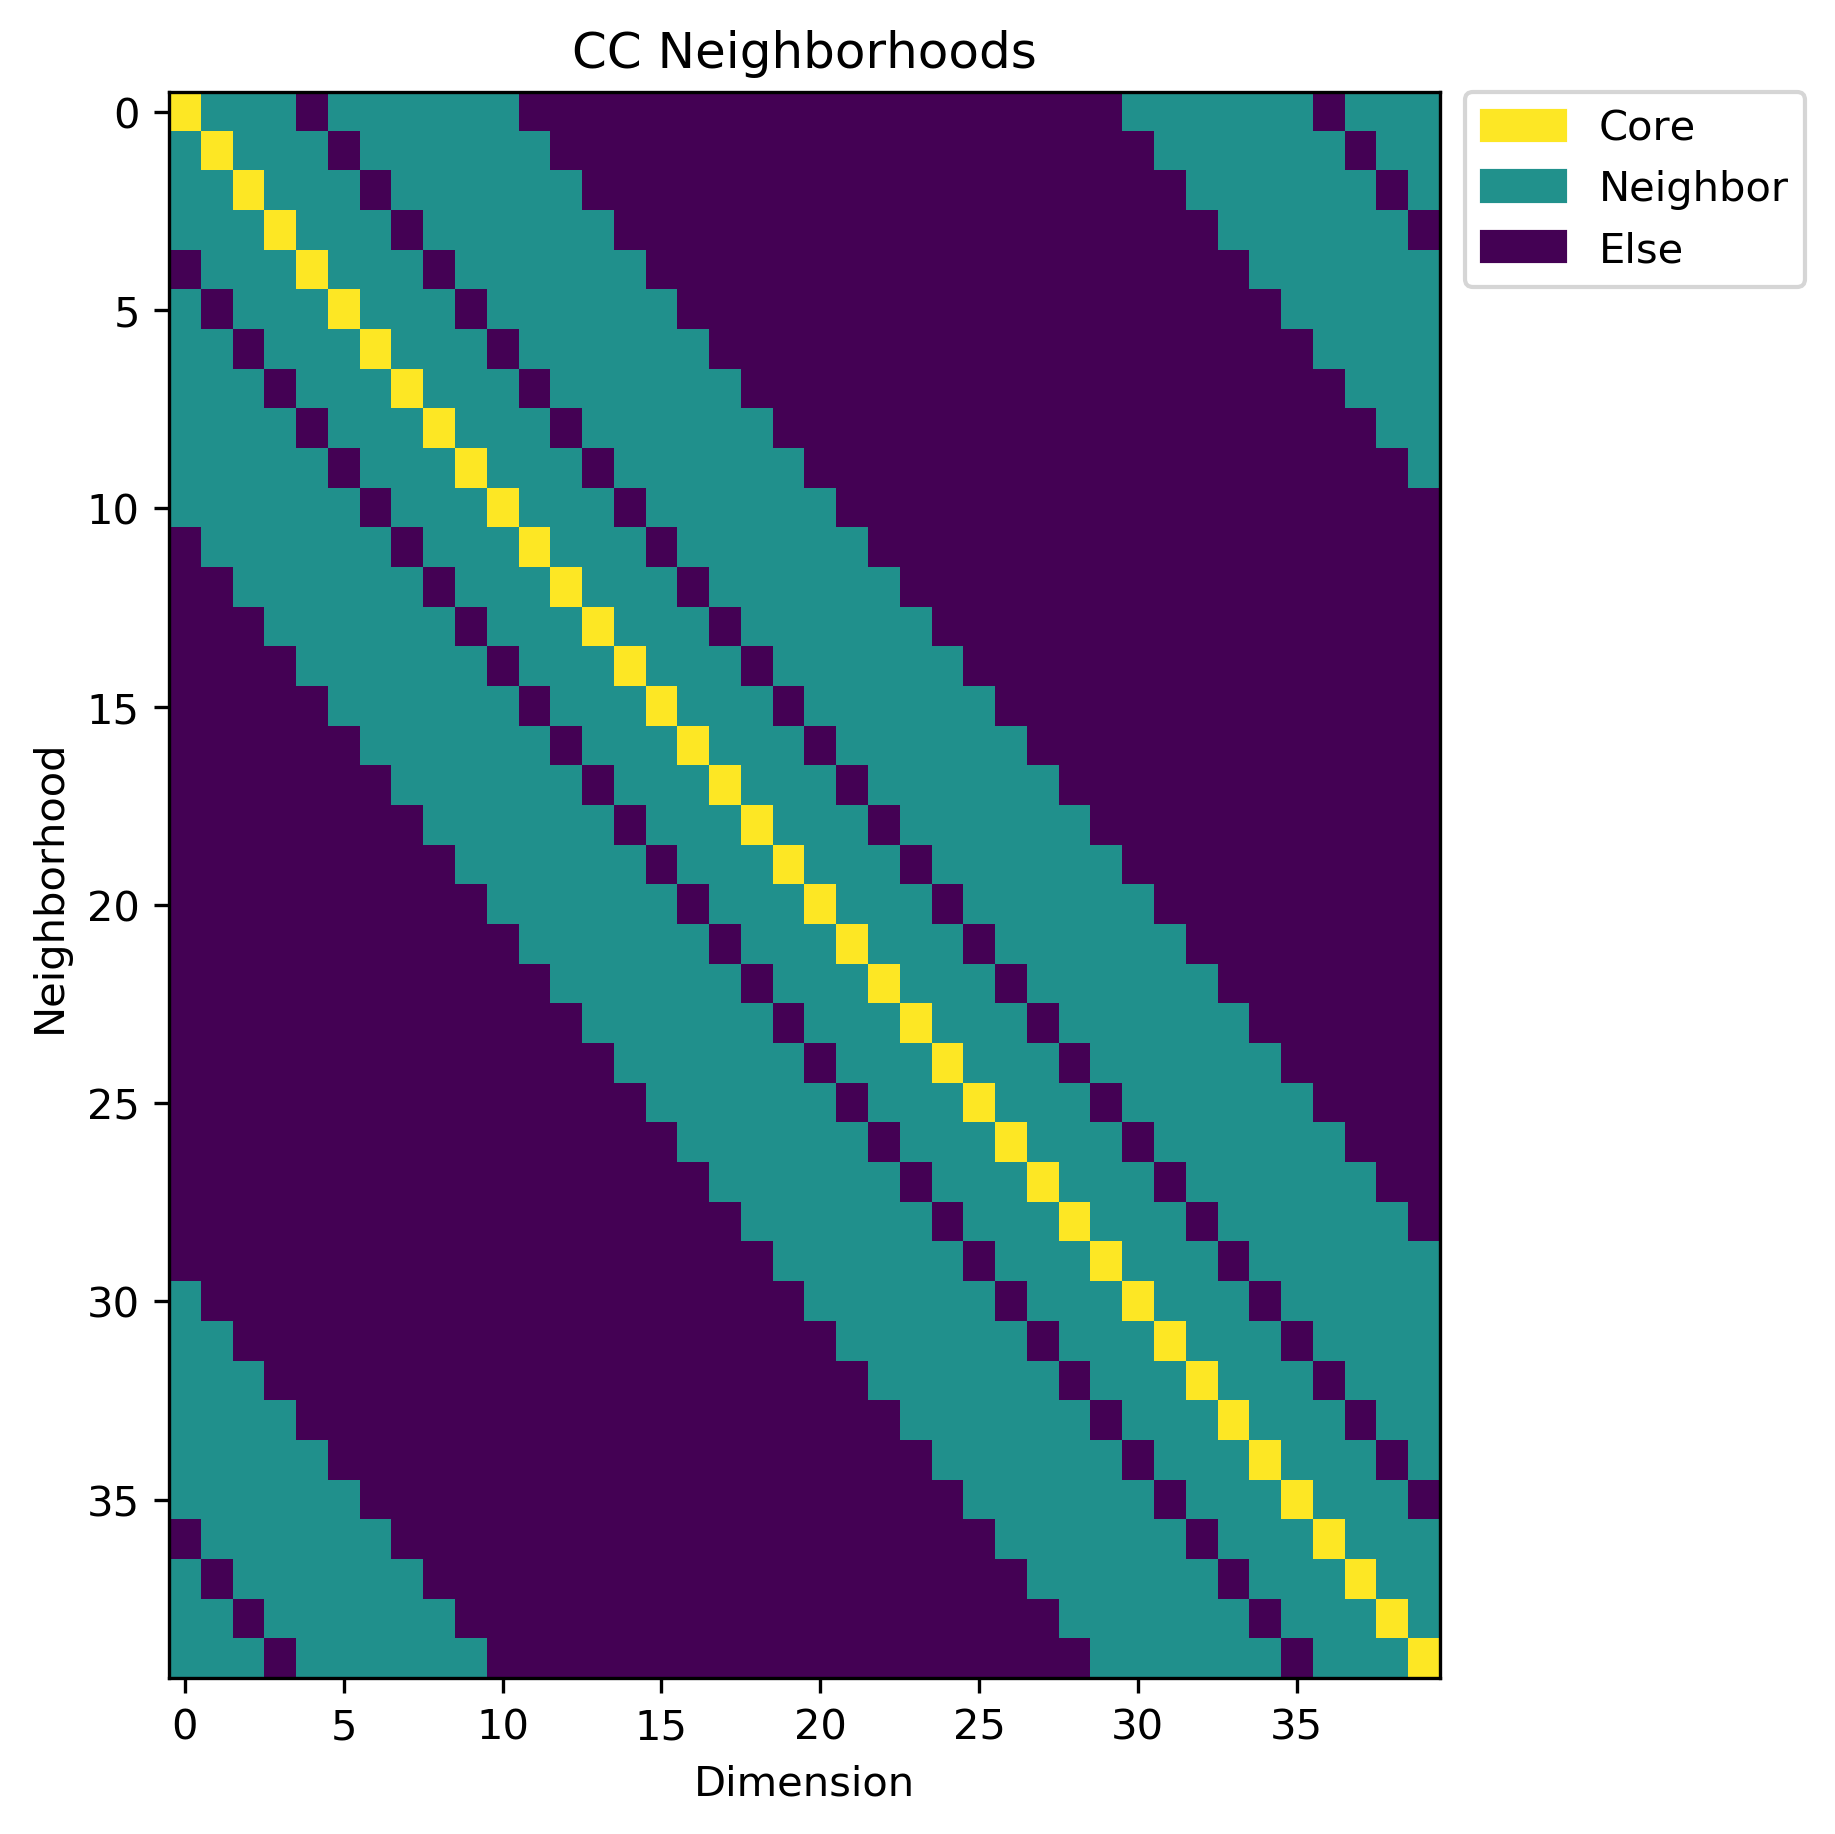

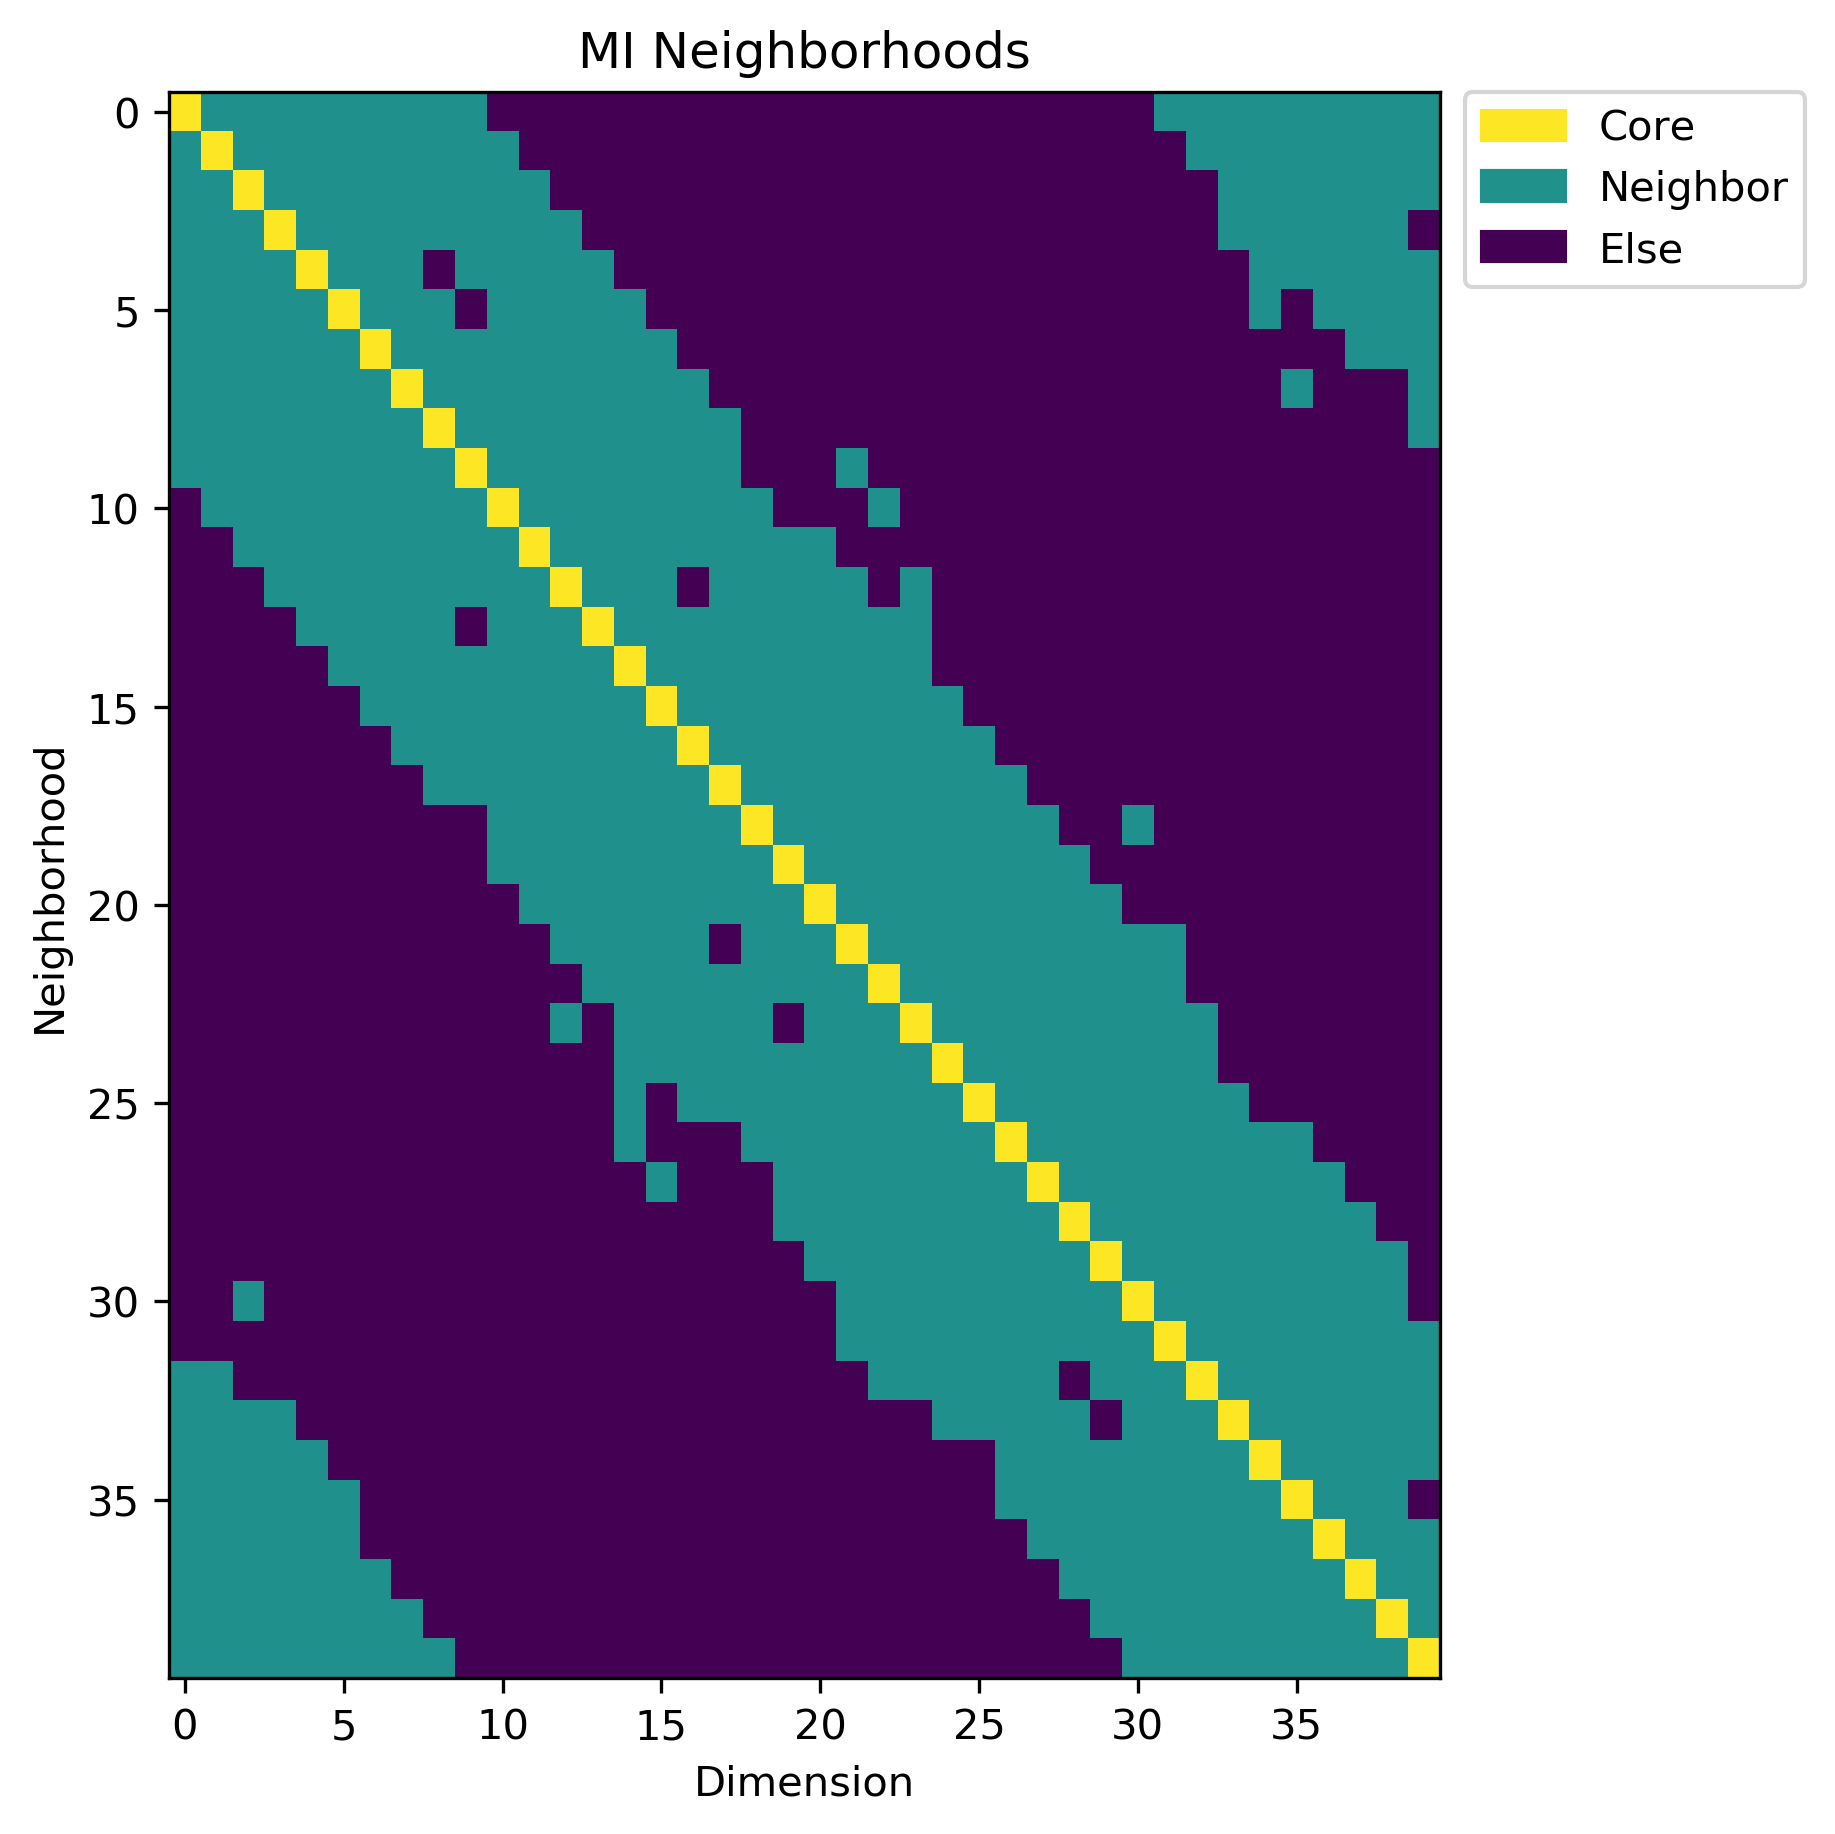

In [19]:
titles = ["SN Neighborhoods", "CC Neighborhoods", "MI Neighborhoods"]
nbhds = [sn_nbhds, cc_nbhds, nmi_nbhds]

for i in range(3):
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 6), constrained_layout=True, dpi=300)
    
    im = ax.imshow(nbhds[i], aspect='auto')
    
    ax.set_title(titles[i])
    ax.set_xlabel("Dimension")
    ax.set_ylabel("Neighborhood")
    
    labels = ['Core', 'Neighbor', 'Else']
    label_values = [2, 1, 0]
    
    force_colorbar_legend(ax, im, labels, label_values)


Here we choose the neighborhood to use for the ESN training and prediction 
below.

Which one to choose, or if you should just calculate/define your own 
neighborhood separate from the three we defined above, depends on 
the problem you are trying to solve.

In [20]:
# loc_nbhds = sn_nbhds
# loc_nbhds = cc_nbhds
loc_nbhds = nmi_nbhds

Create the ESN setup, in this case given by the ESNGenLoc() class. Then train 
and predict with it, as we have done in the other examples.

As training and prediction will take a couple minutes, we also set the console 
logger to "debug", which wil print out the calculation process to the terminal.

In [21]:
n_dim = 3000
w_out_fit_flag = "linear_and_square_r"
avg_degree = 3
regularization = 1e-6
spectral_radius = 0.5
w_in_scale = 0.5
w_in_sparse = True
train_core_only = True

loc_esn = rescomp.esn.ESNGenLoc()
loc_esn.set_console_logger("DEBUG")

loc_esn.create_network(n_dim=n_dim,n_rad=spectral_radius, n_avg_deg=avg_degree)

y_pred, y_test = loc_esn.train_and_predict(
    x_data=signal,
    disc_steps=disc_ts,
    train_sync_steps=sync_ts,
    train_steps=train_ts,
    pred_sync_steps=sync_ts,
    loc_nbhds=loc_nbhds,
    reg_param=regularization,
    w_in_scale=w_in_scale,
    w_in_sparse=w_in_sparse,
    train_core_only=train_core_only,
    w_out_fit_flag=w_out_fit_flag
    )


08-13 18:15:20 [DEBUG  ] Start locality training with 40 neighborhoods
08-13 18:15:20 [DEBUG  ] Deepcopy initial ESN instance for each Neighborhood. Reservoir network matrix are shallow copies though.
08-13 18:15:20 [DEBUG  ] Start Training of Neighborhood 1/40
08-13 18:15:36 [DEBUG  ] Start Training of Neighborhood 2/40
08-13 18:15:52 [DEBUG  ] Start Training of Neighborhood 3/40
08-13 18:16:08 [DEBUG  ] Start Training of Neighborhood 4/40
08-13 18:16:23 [DEBUG  ] Start Training of Neighborhood 5/40
08-13 18:16:39 [DEBUG  ] Start Training of Neighborhood 6/40
08-13 18:16:54 [DEBUG  ] Start Training of Neighborhood 7/40
08-13 18:17:10 [DEBUG  ] Start Training of Neighborhood 8/40
08-13 18:17:26 [DEBUG  ] Start Training of Neighborhood 9/40
08-13 18:17:41 [DEBUG  ] Start Training of Neighborhood 10/40
08-13 18:17:57 [DEBUG  ] Start Training of Neighborhood 11/40
08-13 18:18:12 [DEBUG  ] Start Training of Neighborhood 12/40
08-13 18:18:28 [DEBUG  ] Start Training of Neighborhood 13/40
08

Plot the prediction results.

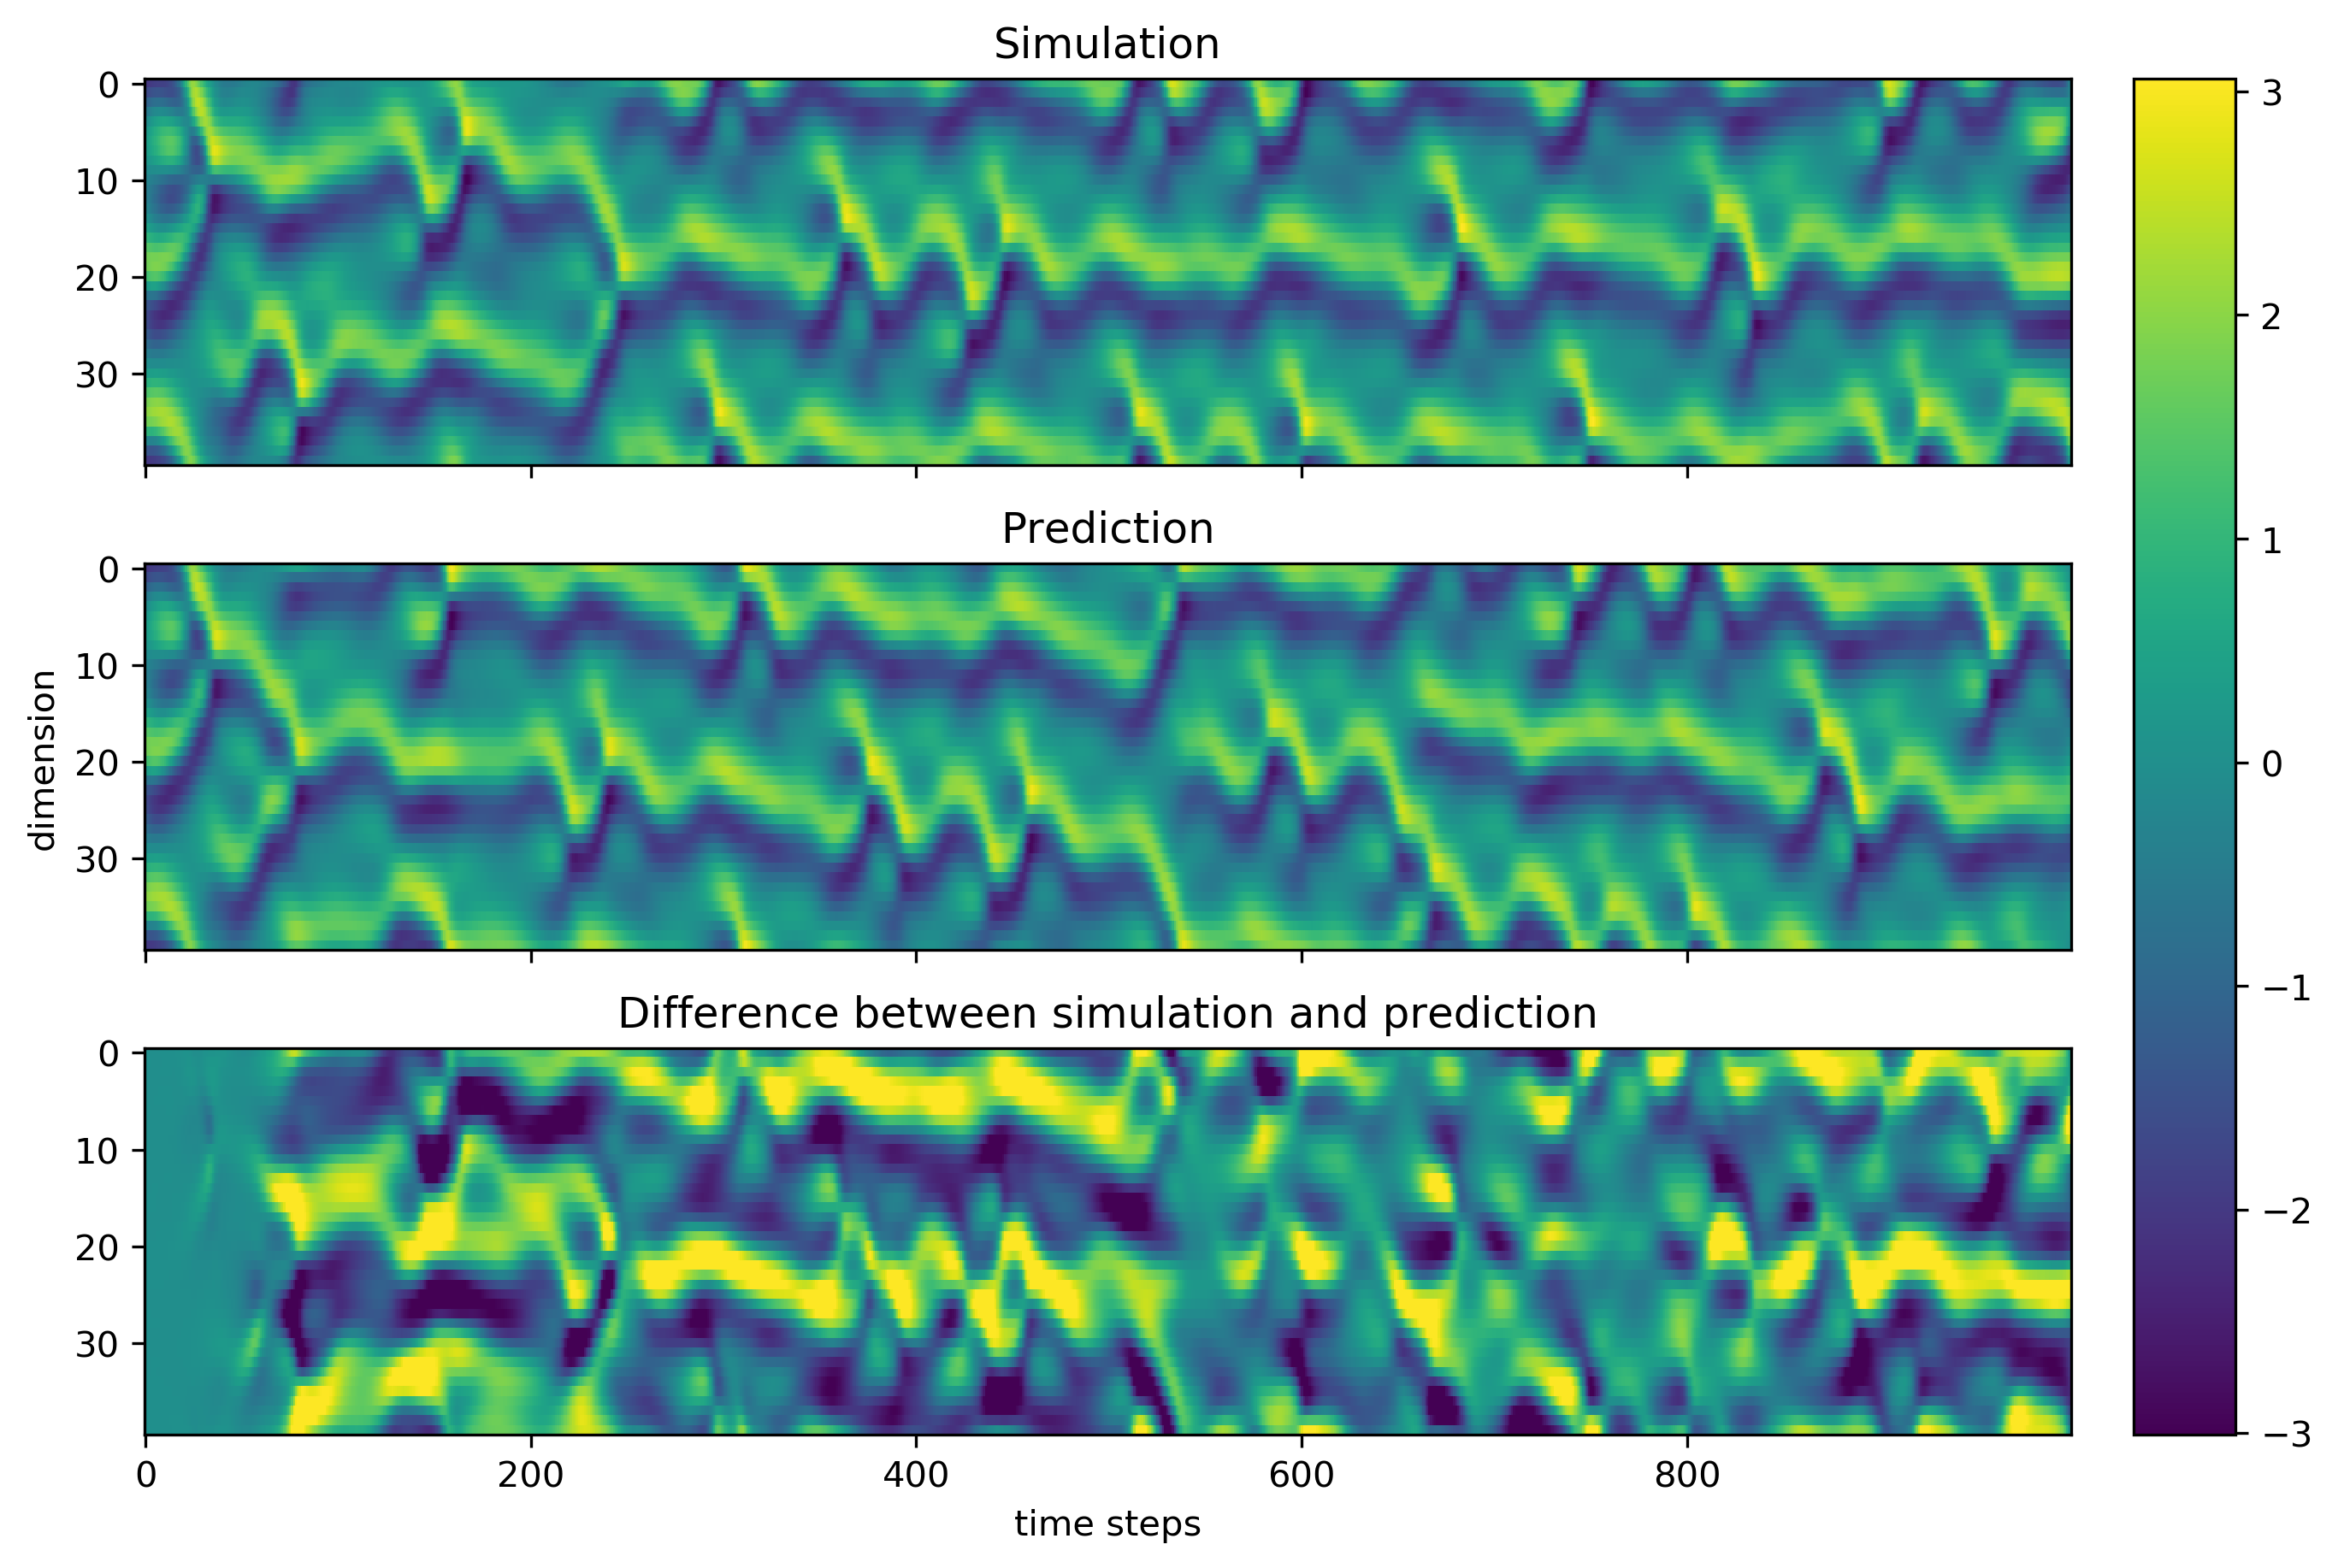

In [22]:
fig, axs = plt.subplots(3, 1, sharex="all", figsize=(9, 6),
                            constrained_layout=True, dpi=300)

vmin = np.min(y_test)
vmax = np.max(y_test)

im = axs[0].imshow(y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[0].set_title("Simulation")

axs[1].imshow(y_pred.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[1].set_title("Prediction")

axs[2].imshow(y_pred.T - y_test.T, aspect='auto', vmin=vmin, vmax=vmax)
axs[2].set_title("Difference between simulation and prediction")

axs[1].set_ylabel("dimension")
axs[2].set_xlabel("time steps")
fig.colorbar(im, ax=axs)
plt.show()